In [1]:
from __future__ import division
import xgboost as xgb
import pandas as pd
import numpy as np
from tqdm import tqdm, tqdm_pandas
tqdm_pandas(tqdm())
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

0it [00:00, ?it/s]


In [7]:
df_train = pd.read_csv("./old/train_data.csv")
df_test = pd.read_csv("./old/test_data.csv")

In [16]:
def collate_similar_feats(df):
    
    sports_feats = ["genre_Athletics" , "genre_Badminton" , "genre_Boxing" , "genre_Cricket" , "genre_Football" , "genre_Formula1" , "genre_FormulaE" , "genre_Hockey" , "genre_IndiaVsSa" , "genre_Kabaddi" , "genre_Sport" , "genre_Swimming" , "genre_Table Tennis" , "genre_Tennis" , "genre_Volleyball"]
    df["generated_sports"] = 0
    
    positive_feats = ["genre_Comedy", "genre_Drama", "genre_Family", "genre_Reality", "genre_Romance", "genre_TalkShow", "genre_Thriller"]
    df["generated_positive"] = 0

    remaining_genres = []
    
    for i in df.columns:
        if "genre_" in i and i not in sports_feats + positive_feats:
#             df.drop(i, axis = 1, inplace = True)
            remaining_genres.append(i)
    
#     celeb_feats = ["genre_TalkShow", "genre_Reality", "genre_Awards"]
#     df["generated_celeb"] = 0

#     drama_feats = ["genre_Drama", "genre_Romance", "genre_Family"]
#     df["generated_drama"] = 0

#     science_feats = ["genre_Documentary", "genre_Science", "genre_Wildlife"]
#     df["generated_science"] = 0

#     action_feats = ["genre_Action", "genre_Thriller"]
#     df["generated_action"] = 0

    for i in sports_feats:
        df["generated_sports"]  = df["generated_sports"] + df[i]
        df.drop(i, axis = 1, inplace = True)
    
    for i in positive_feats:
        df["generated_positive"]  = df["generated_positive"] + df[i]
        df.drop(i, axis = 1, inplace = True)

    sum_wt = sum([df[i] for i in remaining_genres])
    sum_wt += df["generated_sports"] + df["generated_positive"]
    
    df["generated_sports_ratio"] = df["generated_sports"]/sum_wt    
    df["generated_positive_ratio"] = df["generated_positive"]/sum_wt
    
    for i in remaining_genres:
        df[i+"_ratio"] = df[i]/sum_wt
            
#     for i in celeb_feats:
#         df["generated_celeb"]  = df["generated_celeb"] + df[i]
#         df.drop(i, axis = 1, inplace = True)
#     df["celeb_ratio"] = df["generated_celeb"]/df["sum_wt"]
# #     df["generated_celeb"] = (df["generated_celeb"] > 0).astype(int)

#     for i in drama_feats:
#         df["generated_drama"]  = df["generated_drama"] + df[i]
#         df.drop(i, axis = 1, inplace = True)
#     df["drama_ratio"] = df["generated_drama"]/df["sum_wt"]
# #     df["generated_drama"] = (df["generated_drama"] > 0).astype(int)

#     for i in science_feats:
#         df["generated_science"]  = df["generated_science"] + df[i]
#         df.drop(i, axis = 1, inplace = True)
#     df["science_ratio"] = df["generated_science"]/df["sum_wt"]
# #     df["generated_science"] = (df["generated_science"] > 0).astype(int)

#     for i in action_feats:
#         df["generated_action"]  = df["generated_action"] + df[i]
#         df.drop(i, axis = 1, inplace = True)
#     df["action_ratio"] = df["generated_action"]/df["sum_wt"]
# #     df["generated_action"] = (df["generated_action"] > 0).astype(int)

    return df

In [17]:
def collate_tod_feats(df):
    
#     late_night_feats = ["tod_0", "tod_1", "tod_2", "tod_3", "tod_4", "tod_5"]
#     df["generated_late_night"] = 0
    
#     morning_feats = ["tod_6", "tod_7", "tod_8", "tod_9", "tod_10", "tod_11"]    
#     df["generated_morning"] = 0
    
#     afternoon_feats = ["tod_12", "tod_13", "tod_14", "tod_15", "tod_16", "tod_17"]    
#     df["generated_afternoon"] = 0
    
#     evening_feats = [ "tod_18", "tod_19", "tod_20", "tod_21", "tod_22", "tod_23"]    
#     df["generated_evening"] = 0

    positive_tod = ["tod_1", "tod_9", "tod_10", "tod_11", "tod_12", "tod_13", "tod_17", "tod_18", "tod_19", "tod_20", "tod_21"]
    df["positive_tod"] = 0
    
    super_positive_tod = ["tod_0", "tod_14", "tod_15", "tod_16", "tod_22", "tod_23"]
    df["super_positive_tod"] = 0
    
    remaining_tod = []
    
    for i in df.columns:
        if "tod_" in i and i not in positive_tod + super_positive_tod:
            remaining_tod.append(i)

    for i in positive_tod:
        df["positive_tod"] += df[i]
        df.drop(i, axis = 1, inplace = True)

    for i in super_positive_tod:
        df["super_positive_tod"] += df[i]
        df.drop(i, axis = 1, inplace = True)

    sum_wt = sum([df[i] for i in remaining_tod])
    sum_wt += df["positive_tod"] + df["super_positive_tod"]

    df["positive_tod_ratio"] = df["positive_tod"]/sum_wt
    df["super_positive_tod_ratio"] = df["super_positive_tod"]/sum_wt
#     df["indifferent_tod"] = 1 - df["positive_tod"] - df["super_positive_tod"]
                                                       
    for i in remaining_tod:
        df.drop(i, axis = 1, inplace = True)
                        
#     for i in late_night_feats:
#         df["generated_late_night"]  = df["generated_late_night"] + df[i]
#         df.drop(i, axis = 1, inplace = True)

#     for i in morning_feats:
#         df["generated_morning"]  = df["generated_morning"] + df[i]
#         df.drop(i, axis = 1, inplace = True)

#     for i in afternoon_feats:
#         df["generated_afternoon"]  = df["generated_afternoon"] + df[i]
#         df.drop(i, axis = 1, inplace = True)

#     for i in evening_feats:
#         df["generated_evening"]  = df["generated_evening"] + df[i]
#         df.drop(i, axis = 1, inplace = True)

#     sum_time_wt = df_train.generated_late_night + df_train.generated_morning + df_train.generated_afternoon + df_train.generated_evening

#     df["late_night_ratio"] = df["generated_late_night"]/sum_time_wt
#     df["morning_ratio"] = df["generated_morning"]/sum_time_wt
#     df["afternoon_ratio"] = df["generated_afternoon"]/sum_time_wt
#     df["evening_ratio"] = df["generated_evening"]/sum_time_wt
    
    return df

In [18]:
def collate_weekend_weekday(df):
    
#     positive_feats = ["dow_1", "dow_2", "dow_3"]
#     df["positive_day"] = 0

#     negative_feats = ["dow_4", "dow_7"]
#     df["negative_day"] = 0

    weekday_feats = ["dow_1", "dow_2", "dow_3", "dow_4", "dow_5", "dow_6", "dow_7"]
    sum_wt = sum([df[i] for i in weekday_feats])
    df["dow_7"] = df["dow_7"]/sum_wt
    
    for i in weekday_feats:
        if i != "dow_7":
#             df[i] = df[i]/sum_wt
            df.drop(i, axis = 1, inplace = True)
        
#     for i in positive_feats:
#         df["positive_day"] += df[i]
#         df[i] = df[i]/sum_wt
        
#     for i in negative_feats:
#         df["negative_day"] += df[i]
#         df[i] = df[i]/sum_wt
# #         df.drop(i, axis = 1, inplace = True)
        
#     df["positive_perc"] = df["positive_day"]/(df["positive_day"] + df["negative_day"])  

#     try:
#         df["positive_negative_diff"] = (df["positive_day"] - df["negative_day"])/df["negative_day"]
#     except:
#         df["positive_negative_diff"] = 1
            
#     for i in weekday_feats:
#         df[i] = df[i]/sum_wt
        
    return df

In [11]:
title_wt_dict = {}

def title_avg(row):
    
    for title in row.titles.split(","):
        
        try: #to ignore blanks
            title_name, title_wt = title.split(":")
            title_wt_dict.setdefault(str(title_name), []).append(int(title_wt))
        except:
            pass
    
train_data = pd.read_json('train_data.json',orient="index")
train_data.progress_apply(title_avg, axis = 1)
%reset_selective -f train_data

test_data = pd.read_json('test_data.json',orient="index")
test_data.progress_apply(title_avg, axis = 1)
%reset_selective -f test_data

with open("title_wt_dict.pkl", "wb") as handle:
    pickle.dump(title_wt_dict, handle)

200000it [00:18, 10575.26it/s]               
100000it [00:10, 9515.39it/s]        


In [4]:
title_wt_mean = {}
title_wt_median = {}

for i in tqdm(title_wt_dict):
    title_wt_mean[i] = np.mean(title_wt_dict[i])
    title_wt_median[i] = np.median(title_wt_dict[i])    
    
with open("title_wt_mean.pkl", "wb") as handle:
    pickle.dump(title_wt_mean, handle)
with open("title_wt_median.pkl", "wb") as handle:
    pickle.dump(title_wt_median, handle)

100%|██████████| 11890/11890 [00:01<00:00, 9617.50it/s] 


In [12]:
title_segment_dict = {}

def title_segment_avg(row):
    
    for title in row.titles.split(","):
        
        try: #to ignore blanks
            title_name, title_wt = title.split(":")
            title_segment_dict.setdefault(str(title_name), []).append(int(title_wt))
        except:
            pass

train_data = pd.read_json('train_data.json',orient="index")
train_data[train_data.segment == "pos"].progress_apply(title_segment_avg, axis = 1)
%reset_selective -f train_data

with open("title_segment_dict.pkl", "wb") as handle:
    pickle.dump(title_segment_dict, handle)

15255it [00:01, 13907.17it/s]        


In [5]:
title_segment_mean = {}
title_segment_median = {}

for i in tqdm(title_segment_dict):
    title_segment_mean[i] = np.mean(title_segment_dict[i])
    title_segment_median[i] = np.median(title_segment_dict[i])    
    
with open("title_segment_mean.pkl", "wb") as handle:
    pickle.dump(title_segment_mean, handle)
with open("title_segment_median.pkl", "wb") as handle:
    pickle.dump(title_segment_median, handle)

100%|██████████| 4295/4295 [00:00<00:00, 14616.79it/s]


In [8]:
with open('title_wt_dict.pkl', 'rb') as handle:
    title_wt_dict = pickle.load(handle)
with open('title_wt_mean.pkl', 'rb') as handle:
    title_wt_mean = pickle.load(handle)
with open('title_wt_median.pkl', 'rb') as handle:
    title_wt_median = pickle.load(handle)
    
with open('title_segment_dict.pkl', 'rb') as handle:
    title_segment_dict = pickle.load(handle)
with open('title_segment_mean.pkl', 'rb') as handle:
    title_segment_mean = pickle.load(handle)
with open('title_segment_median.pkl', 'rb') as handle:
    title_segment_median = pickle.load(handle)

def title_analysis(row):
    
    title_dict = {}
    segment_view_ratio = 0
    segment_wt_mean_ratio = 0
    segment_wt_median_ratio = 0

    for title in row.titles.split(","):

        try: #to ignore blanks

            title_name, title_wt = title.split(":")
            
            #Individual dict
            title_dict[str(title_name)] = int(title_wt)
            
            #Collective features
            if str(title_name) in title_segment_dict:
                segment_view_ratio += len(title_segment_dict[str(title_name)])/len(title_wt_dict[str(title_name)])
                segment_wt_mean_ratio += title_segment_mean[str(title_name)]/title_wt_mean[str(title_name)]
                segment_wt_median_ratio += title_segment_median[str(title_name)]/title_wt_median[str(title_name)]

        except:
            pass
        
    num_titles = len(row.titles.split(","))
    
    if num_titles > 0:
        segment_view_ratio /= num_titles
        segment_wt_mean_ratio /= num_titles
        segment_wt_median_ratio /= num_titles
    else:
        segment_view_ratio = 0
        segment_wt_mean_ratio = 0
        segment_wt_median_ratio = 0
        
        
    if sum(title_dict.values()) > 0:

        return pd.Series({
            "titles_gt_600": sum( x >= 600 for x in title_dict.values() )/len(title_dict),
            "titles_mean": np.mean(title_dict.values()),
            "titles_median": np.median(title_dict.values()),
            "titles_max": max(title_dict.values()),
            "titles_max_perc": max(title_dict.values())/sum(title_dict.values()),
            "segment_view_ratio": segment_view_ratio,
            "segment_wt_mean_ratio": segment_wt_mean_ratio,
            "segment_wt_median_ratio": segment_wt_median_ratio
        })
    
    else:
        return pd.Series({
            "titles_gt_600": 0,
            "titles_mean": 0,
            "titles_median": 0,
            "titles_max": 0,
            "titles_max_perc": 0,
            "segment_view_ratio": segment_view_ratio,
            "segment_wt_mean_ratio": segment_wt_mean_ratio,
            "segment_wt_median_ratio": segment_wt_median_ratio
        })
    
train_data = pd.read_json('train_data.json',orient="index")
train_title = train_data.progress_apply(title_analysis, axis = 1)
%reset_selective -f train_data
train_title.index = df_train.index

test_data = pd.read_json('test_data.json',orient='index')
test_title = test_data.progress_apply(title_analysis, axis = 1)
%reset_selective -f test_data
test_title.index = df_test.index

with open("train_title.pkl", "wb") as handle:
    pickle.dump(train_title, handle)
with open("test_title.pkl", "wb") as handle:
    pickle.dump(test_title, handle)

100001it [01:17, 1284.24it/s]        


In [9]:
with open('train_title.pkl', 'rb') as handle:
    train_title = pickle.load(handle)
with open('test_title.pkl', 'rb') as handle:
    test_title = pickle.load(handle)    

df_train = pd.concat([df_train, train_title], axis = 1)
df_test = pd.concat([df_test, test_title], axis = 1)

In [19]:
df_train = collate_similar_feats(df_train)
df_test = collate_similar_feats(df_test)

In [20]:
df_train = collate_tod_feats(df_train)
df_test = collate_tod_feats(df_test)

In [21]:
df_train = collate_weekend_weekday(df_train)
df_test = collate_weekend_weekday(df_test)

In [22]:
df_train.to_csv("./new/train_data.csv", index = False)
df_test.to_csv("./new/test_data.csv", index = False)

In [85]:
import seaborn as sns
corr = df_train.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

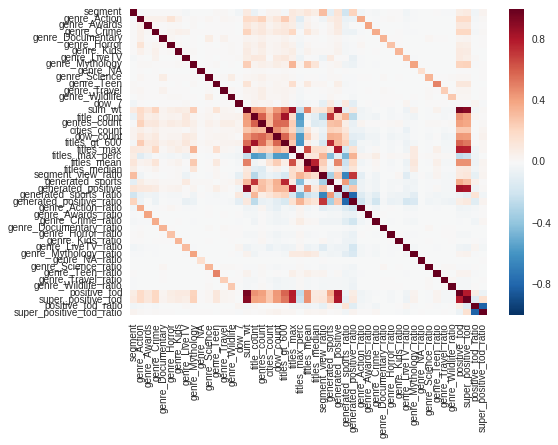

In [86]:
import matplotlib.pyplot as plt
plt.show()

In [72]:
np.mean(df_train[df_train.segment == 0].title_count)

12.115478091423313

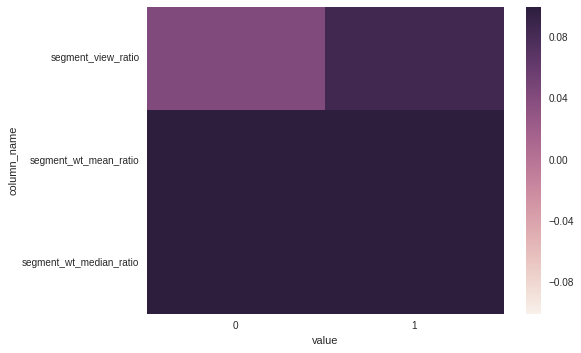

In [13]:
# cols = ["generated_sports", "generated_celeb", "generated_drama"]
cols = [i for i in df_train.columns if "segment" in i]
cols.remove("segment")

non_segment_means = []
segment_means = []
for i in cols:
    non_segment_means.append(np.mean(df_train[df_train.segment == 0][i]))    
    segment_means.append(np.mean(df_train[df_train.segment == 1][i]))

new_df = pd.DataFrame({"column_name":cols+cols, "value":[0]*len(cols) + [1]*len(cols), "y_mean":non_segment_means + segment_means})
new_df = new_df.pivot('column_name', 'value', 'y_mean')

# plt.figure(figsize=(8,80))
sns.heatmap(new_df)
plt.show()

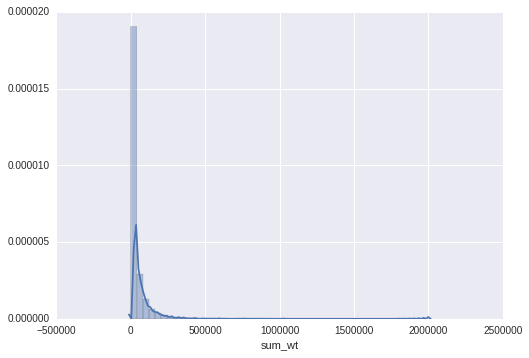

In [29]:
sns.distplot(df_train[df_train.segment == 1].sum_wt)
plt.show()

In [35]:
df_train[df_train.segment == 1].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
segment,15255.0,1.000000e+00,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00
genre_Action,15255.0,1.873776e-02,0.105561,0.000000,0.000000,0.000000,0.000000,1.000000e+00
genre_Awards,15255.0,4.352549e-03,0.047546,0.000000,0.000000,0.000000,0.000000,1.000000e+00
genre_Crime,15255.0,1.983909e-02,0.114069,0.000000,0.000000,0.000000,0.000000,1.000000e+00
genre_Documentary,15255.0,3.483273e-04,0.014432,0.000000,0.000000,0.000000,0.000000,9.808612e-01
genre_Horror,15255.0,4.110050e-03,0.051497,0.000000,0.000000,0.000000,0.000000,1.000000e+00
genre_Kids,15255.0,4.130145e-03,0.048697,0.000000,0.000000,0.000000,0.000000,1.000000e+00
genre_LiveTV,15255.0,5.867077e-03,0.057672,0.000000,0.000000,0.000000,0.000000,1.000000e+00
genre_Mythology,15255.0,1.508357e-02,0.106242,0.000000,0.000000,0.000000,0.000000,1.000000e+00
genre_NA,15255.0,1.024254e-06,0.000127,0.000000,0.000000,0.000000,0.000000,1.562500e-02
